# 清洗水库数据

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
reservoir = pd.read_csv(r'../data/hydrology/reservoir.csv', index_col=0)
reservoir.head()

,年,亿立方米,名称,亿立方米.1,名称.1,亿立方米.2,名称.2,亿立方米.3,名称.3
0,1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1958,40.000,东平湖围堤,NaN,NaN,NaN,NaN,NaN,NaN
3,1959,2.160,盐锅峡,NaN,NaN,NaN,NaN,NaN,NaN
4,1960,0.168,红领巾水库,1.1,卧虎山水库,58.9,三门峡,NaN,NaN


In [3]:
import requests
import json

def convert_name_to_gps(address):
    secret_key = 'tSdDxv3r1hRtOZ2LGQG5pSyavKSx4Ia3'  # 我的百度API token
    api = "http://api.map.baidu.com/geocoding/v3/?address={0}&output=json&ak={1}"
    baidu_map_api = api.format(address, secret_key)
    content = json.loads(requests.get(baidu_map_api).text)
    if content['status'] is 0:
        gps = content['result']['location']
        lng, lat = gps['lng'], gps['lat']
        if content['result']['precise'] is 0:
            if content['result']['confidence'] < 30:
                print("{} is not precise, error > 5km, please check".format(address))
    else:
        print("{} is not match, please check".format(address))
        return 0., 0.
    return lng, lat


def convert_name_to_province(name):
    lng, lat = convert_name_to_gps(name)
    secret_key = 'tSdDxv3r1hRtOZ2LGQG5pSyavKSx4Ia3'  # 百度密钥
    # 注意coordtype为wgs84ll(GPS经纬度),否则定位会出现偏差
    api = "http://api.map.baidu.com/reverse_geocoding/v3/?ak={2}&output=json&coordtype=wgs84ll&location={0},{1}"
    baidu_map_api = api.format(lat, lng, secret_key)
    content = requests.get(baidu_map_api).text
    gps_address = json.loads(content)
    # 结构化的地址
    formatted_address = gps_address["result"]["formatted_address"]
    # 国家（若需访问境外POI，需申请逆地理编码境外POI服务权限）
    country = gps_address["result"]["addressComponent"]["country"]
    # 省
    province = gps_address["result"]["addressComponent"]["province"]
    # 城市
    city = gps_address["result"]["addressComponent"]["city"]
    return province


convert_name_to_province("红领巾水库")

'河北省'

In [4]:
reservoir_names = []
for col in ['名称', '名称.1', '名称.2', '名称.3']:
    reservoir_names.extend(reservoir[col].dropna().unique())

name_province = {}
for name in reservoir_names:
    name_province[name] = convert_name_to_province(name)
    
name_province

青铜峡 is not precise, error > 5km, please check
天桥水电站 is not precise, error > 5km, please check
八盘峡水电站 is not match, please check
黄河沙坡头水利枢纽工程 is not precise, error > 5km, please check
苏只水电站 is not match, please check
黄河龙口水利枢纽 is not precise, error > 5km, please check
三盛公枢纽 is not match, please check
拉西瓦水电站 is not match, please check
三门峡 is not precise, error > 5km, please check


{'东平湖围堤': '山东省',
 '盐锅峡': '辽宁省',
 '红领巾水库': '河北省',
 '汾河水库': '山西省',
 '巴家嘴水库': '湖北省',
 '陆浑水库': '山西省',
 '雪野水库': '陕西省',
 '青铜峡': '宁夏回族自治区',
 '刘家峡': '甘肃省',
 '羊毛湾水库': '浙江省',
 '天桥水电站': '山东省',
 '冯家山水库': '四川省',
 '八盘峡水电站': '',
 '东大滩水库': '重庆市',
 '龙羊峡水电站': '青海省',
 '王瑶水库': '广西壮族自治区',
 '故县水库': '山东省',
 '石头河水库': '陕西省',
 '克孜尔水库': '新疆维吾尔自治区',
 '李家峡水电站': '陕西省',
 '万家寨水利枢纽工程': '重庆市',
 '济南鹊山引黄调蓄水库': '山西省',
 '黄河源水电站': '辽宁省',
 '尼那水电站': '西藏自治区',
 '黄河沙坡头水利枢纽工程': '宁夏回族自治区',
 '苏只水电站': '',
 '西霞院反调节水库': '河南省',
 '乌金峡水电站': '贵州省',
 '黄河龙口水利枢纽': '山东省',
 '积石峡水电站': '青海省',
 '沁河河口村水库': '河北省',
 '黄丰水电站': '浙江省',
 '卧虎山水库': '河北省',
 '三盛公枢纽': '',
 '文峪河水库': '河南省',
 '大峡水电站': '福建省',
 '山东博兴纯化水库': '山东省',
 '黑泉水利枢纽工程': '北京市',
 '公伯峡水电站': '青海省',
 '直岗拉卡水电站': '浙江省',
 '康扬水电站': '北京市',
 '寺沟峡水电站': '天津市',
 '拉西瓦水电站': '',
 '班多水电站': '贵州省',
 '三门峡': '河南省',
 '小浪底水利枢纽': '河南省',
 '小峡水电站': '湖北省',
 '汾河二库水利枢纽': '山西省'}

In [5]:
correct = {
    '盐锅峡': '甘肃省',
    '巴家嘴水库': '甘肃省',
    '陆浑水库': '河南省',
    '雪野水库': '山东省',
    '羊毛湾水库': '山西省',
    '天桥水电站': '山西省',
    '冯家山水库': '陕西省',
    '八盘峡水电站': '甘肃省',
    '东大滩水库': '青海省',
    '王瑶水库': '陕西省',
    '李家峡水电站': '青海省',
    '克孜尔水库': 'UnKnown',
    '万家寨水利枢纽工程': '山西省',
    '济南鹊山引黄调蓄水库': '山东省',
    '黄河源水电站': '青海省',
    '尼那水电站': '青海省',
    '苏只水电站': '青海省',
    '乌金峡水电站': '甘肃省',
    '黄河龙口水利枢纽': '山西省',
    '沁河河口村水库': '山西省',
    '大峡水电站': '甘肃省',
    '黄丰水电站': '青海省',
    '卧虎山水库': '山东省',
    '三盛公枢纽': '内蒙古',
    '文峪河水库': '山西省',
    '黑泉水利枢纽工程': '青海省',
    '直岗拉卡水电站': '青海省',
    '康扬水电站': '青海省',
    '寺沟峡水电站': '甘肃省',
    '拉西瓦水电站': '青海省',
    '班多水电站': '青海省',
    '小峡水电站': '甘肃省',
}

# 修改不正确的判断
for k, v in correct.items():
    if k in name_province:
        name_province[k] = v

print("There are total {} reservoires.".format(len(reservoir_names)))
print("There are {} ({:.2%}) reservoires' name need correction.".format(len(correct), len(correct)/len(reservoir_names)))

There are total 48 reservoires.
There are 32 (66.67%) reservoires' name need correction.


(array([5., 3., 2., 2., 2., 1., 1., 2., 1., 1., 0., 1., 2., 4., 5., 5., 4.,
        6., 1., 1.]),
 array([1958. , 1960.9, 1963.8, 1966.7, 1969.6, 1972.5, 1975.4, 1978.3,
        1981.2, 1984.1, 1987. , 1989.9, 1992.8, 1995.7, 1998.6, 2001.5,
        2004.4, 2007.3, 2010.2, 2013.1, 2016. ]),
 <a list of 20 Patch objects>)

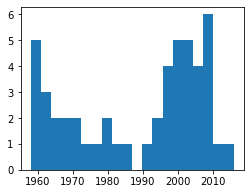

In [6]:
year_list = []
data_list = []
for row in reservoir[['亿立方米', '亿立方米.1', '亿立方米.2', '亿立方米.3']].fillna(0.).set_index(reservoir['年']).itertuples(index=True):
    yr = row[0]
    for i in row[1:]:
        if i > 0:
            year_list.append(yr)
            data_list.append(i)

fig, ax = plt.subplots(figsize=(4, 3))
plt.hist(year_list, 20)

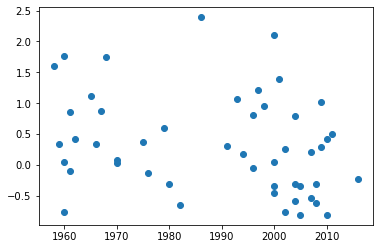

In [7]:
plt.scatter(x=year_list, y=np.log10(np.array(data_list)))

In [8]:
PROVINCE_LIST = ['青海省',
                 '甘肃省', '宁夏回族自治区', '内蒙古自治区',
                 '陕西省', '山西省',
                 '河南省', '河北省', '山东省']

PROVINCE_TO_SUBREGION = {
    "SR": [PROVINCE_LIST[0]] + ['青海', 'Qinghai'],
    "UR": PROVINCE_LIST[1:4] + ["甘肃", "宁夏", '内蒙', 'Gansu', 'Ningxia', 'Neimeng'],
    "MR": PROVINCE_LIST[4:6] + ["陕西", "山西", 'Shanxi', 'Shaanxi'],
    "DR": PROVINCE_LIST[6:] + ["河南", "河北", "天津", "山东", 'Henan', 'Shandong']
}

def judge_province(row, how='capacity'):
    result = {region: 0 for region in ['SR', 'UR', 'MR', 'DR']}
    result2 = {region: 0 for region in ['SR', 'UR', 'MR', 'DR']}
    names = [row[col] for col in ['名称', '名称.1', '名称.2', '名称.3']]
    rcs = [row[col] for col in ['亿立方米', '亿立方米.1', '亿立方米.2', '亿立方米.3']]
    for name, rc in zip(names, rcs):
        if name is np.nan or rc is np.nan:
            continue
        else:
            province = name_province.get(name)
            for k, v in PROVINCE_TO_SUBREGION.items():
                if province in v:
                    result[k] += rc
                    result2[k] += 1
    if how == 'capacity': return result
    elif how == 'amount': return result2

new_reservoirs = pd.DataFrame(reservoir.apply(judge_province, axis=1).values.tolist(), index=reservoir['年'].tolist())
new_reservoirs.head()

,SR,UR,MR,DR
1956,0.0,0.00,0.0,0.000
1957,0.0,0.00,0.0,0.000
1958,0.0,0.00,0.0,40.000
1959,0.0,2.16,0.0,0.000
1960,0.0,0.00,0.0,60.168


In [9]:
num_reservoirs = pd.DataFrame(reservoir.apply(judge_province, axis=1, how='amount').values.tolist(), index=reservoir['年'].tolist())
num_reservoirs.head()

,SR,UR,MR,DR
1956,0,0,0,0
1957,0,0,0,0
1958,0,0,0,1
1959,0,1,0,0
1960,0,0,0,3


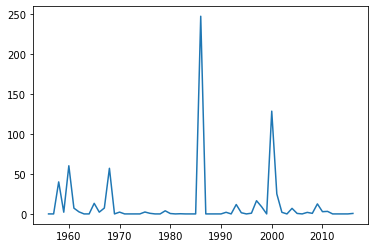

In [10]:
new_reservoirs.sum(axis=1).plot()
plt.show();

In [11]:
new_reservoirs

,SR,UR,MR,DR
1956,0.00,0.00,0.0,0.000
1957,0.00,0.00,0.0,0.000
1958,0.00,0.00,0.0,40.000
1959,0.00,2.16,0.0,0.000
1960,0.00,0.00,0.0,60.168
...,...,...,...,...
2012,0.00,0.00,0.0,0.000
2013,0.00,0.00,0.0,0.000
2014,0.00,0.00,0.0,0.000
2015,0.00,0.00,0.0,0.000


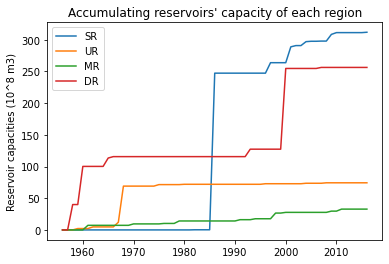

In [12]:
reservoirs_capacity_cumulating = new_reservoirs.cumsum()
reservoirs_capacity_cumulating.plot()
plt.title("Accumulating reservoirs' capacity of each region")
plt.ylabel("Reservoir capacities (10^8 m3)")
plt.show();

# 最终作图

In [13]:
# 全局变量
import matplotlib.colors as col

period_colors = ['#0889A6', '#F1801F', '#006C43']

region_colors = ["#0077b6", "#e07a5f", "#f2cc8f","#81b29a"]
index_colors = ['#7D9DB5', '#B8B08D', '#F2D492']
regional_colormap = col.ListedColormap(region_colors, 'indexed')

bins = 7

In [14]:
num = np.array(year_list)
p1 = num[num<1978]
p2 = num[(num<1993)&(num>=1978)]
p3 = num[num>=1993]

In [15]:
len(p1)
len(p2)
len(p3)

28

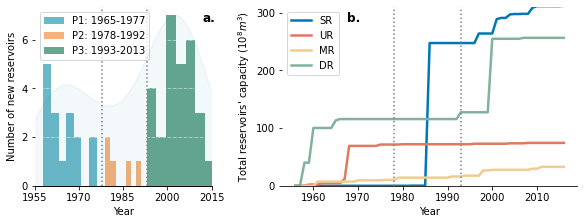

In [16]:
# %config InlineBackend.figure_format ='retina'
import seaborn as sns
from matplotlib.gridspec import GridSpec

# 配置画布
fig = plt.figure(figsize=(8, 3), constrained_layout=True)   
gs = GridSpec(1, 2, figure=fig, width_ratios=[3, 5])
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1])

# 作图 1
ax1.hist(p1, bins=7, histtype="stepfilled", alpha=0.6, color=period_colors[0], label='P1: 1965-1977')
ax1.hist(p2, bins=7, histtype="stepfilled", alpha=0.6, color=period_colors[1], label='P2: 1978-1992')
ax1.hist(p3, bins=7, histtype="stepfilled", alpha=0.6, color=period_colors[2], label='P3: 1993-2013')

# 作图2
ax2 = ax1.twinx()
sns.kdeplot(year_list, shade=True, ax=ax2, alpha=0.05)

# 作图3
reservoirs_capacity_cumulating.plot(ax=ax3, colormap=regional_colormap, lw=2.5)


# 修饰图1
ax1.set_yticks(np.arange(0, 7.9, 2))
ax1.set_xticks(np.arange(1955, 2016, 15))
ax1.legend(loc=2)
ax1.yaxis.grid(color='white', linestyle='-.', linewidth=0.5)
ax1.set_ylabel("Number of new reservoirs")
ax1.text(2014, 6.9, 'a.', ha='center', va='center', weight='bold', size='large')

# 修饰图2
ax2.set_xlim(1955, 2015)
ax2.axes.get_yaxis().set_visible(False)

# 修饰图3
ax3.set_yticks(np.arange(0, 310, 100))
ax3.set_ylabel("Total reservoirs' capacity ($10^8 m^3$)")
ax3.set_ylim(0, 310)
ax3.text(1969, 290, 'b.', ha='center', va='center', weight='bold', size='large')

for ax in [ax1, ax3]:
    ax.axvline(1978, color='gray', ls=':', lw=1.5)
    ax.axvline(1993, color='gray', ls=':', lw=1.5)
    ax.set_xlabel('Year')

for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.savefig('../figures/sup/reservoirs.jpg', dpi=300)
plt.savefig('../figures/sup/reservoirs.pdf', dpi=300)
plt.show();